The goal of this code is to predict how long a flight will be delayed given that we already know that the flight will be delayed.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
#preprocessing data
df = pd.read_csv('data/preprocessed_df.csv')

#remove any rows with DepDelay <= 0
df = df[df['DepDelay'] > 0]

#remove other columns
#DaysSince, MinSince - Used to make other variables and dont provide any information
#FlightDate - Information is already in other columns(Year, Month, DayofMonth, DayOfWeek)
#is_holiday, is_day_before_holiday - is_holiday_week captures more information
#Tail_Number - It's a unique identifier for each plane
#Flight_Number_Reporting_Airline - It's a unique identifier for each flight

df = df.drop(columns=['DaysSince', 'MinSince', 'FlightDate', 'is_holiday', 'is_day_before_holiday', 'Tail_Number', 'Flight_Number_Reporting_Airline'])

print(df.columns)
print(df.shape)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Reporting_Airline', 'OriginAirportSeqID', 'Origin', 'OriginCityName',
       'OriginState', 'DestAirportSeqID', 'Dest', 'DestCityName', 'DestState',
       'CRSDepTime', 'DepDelay', 'CRSArrTime', 'Cancelled', 'Diverted',
       'CRSElapsedTime', 'Distance', 'is_holiday_week', 'OriginFlightDensity',
       'Visibility', 'WindSpeed'],
      dtype='object')
(686346, 25)


In [4]:
# turn all non-numerical data into numerical data, using .factorize()
object_cols = df.select_dtypes(include='object').columns
df_nums = df.copy()
for col in object_cols:
    df_nums[col], _ = pd.factorize(df[col])

#This shows the mapping of the categorical data to numerical data
print("Conversions of categorical data to numerical data:")
for col in object_cols:
    print(f"{col}:")
    print("Original:", df[col].unique())
    print("Converted:", df_nums[col].unique())

Conversions of categorical data to numerical data:
Reporting_Airline:
Original: ['UA' 'DL' 'WN' 'AA' 'OO']
Converted: [0 1 2 3 4]
Origin:
Original: ['ATL' 'CLT' 'DEN' 'DFW' 'IAH' 'LAX' 'ORD' 'PHX' 'SFO']
Converted: [0 1 2 3 4 5 6 7 8]
OriginCityName:
Original: ['Atlanta, GA' 'Charlotte, NC' 'Denver, CO' 'Dallas/Fort Worth, TX'
 'Houston, TX' 'Los Angeles, CA' 'Chicago, IL' 'Phoenix, AZ'
 'San Francisco, CA']
Converted: [0 1 2 3 4 5 6 7 8]
OriginState:
Original: ['GA' 'NC' 'CO' 'TX' 'CA' 'IL' 'AZ']
Converted: [0 1 2 3 4 5 6]
Dest:
Original: ['ORD' 'LAX' 'DEN' 'PHX' 'DFW' 'SFO' 'CLT' 'IAH' 'ATL']
Converted: [0 1 2 3 4 5 6 7 8]
DestCityName:
Original: ['Chicago, IL' 'Los Angeles, CA' 'Denver, CO' 'Phoenix, AZ'
 'Dallas/Fort Worth, TX' 'San Francisco, CA' 'Charlotte, NC' 'Houston, TX'
 'Atlanta, GA']
Converted: [0 1 2 3 4 5 6 7 8]
DestState:
Original: ['IL' 'CA' 'CO' 'AZ' 'TX' 'NC' 'GA']
Converted: [0 1 2 3 4 5 6]


In [5]:
#convert DepDelay into bins
#1 - 5 minutes
#2 - 5-15
#3 - 15-30
#4 - 30-60
#5 - 1hr-2hr
#6 - 2-5hr
#7 - 5-10hr
#8 - Over 10hr

bins = [0, 5, 15, 30, 60, 120, 300, 600, df['DepDelay'].max()]
labels = [0, 1, 2, 3, 4, 5, 6, 7]
df_nums['DepDelay'] = pd.cut(df_nums['DepDelay'], bins=bins, labels=labels)

print(df_nums['DepDelay'].head(10))
print(df_nums['DepDelay'].value_counts())

2     0
3     2
5     0
7     0
10    1
16    2
23    2
28    1
31    1
33    1
Name: DepDelay, dtype: category
Categories (8, int64): [0 < 1 < 2 < 3 < 4 < 5 < 6 < 7]
DepDelay
0    188705
1    171911
2    119619
3    100529
4     68756
5     32937
6      3195
7       694
Name: count, dtype: int64


In [13]:
#split the data into training and testing
X = df_nums.drop(columns=['DepDelay'])
y = df_nums['DepDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#Split data into training and testing
#data before 2018 will be used for training
#data from 2018 will be used for testing

train = df_nums[df_nums['Year'] < 2018]
test = df_nums[df_nums['Year'] == 2018]

X_train = train.drop(columns=['DepDelay'])
y_train = train['DepDelay']

X_test = test.drop(columns=['DepDelay'])
y_test = test['DepDelay']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(558102, 24)
(558102,)
(128244, 24)
(128244,)


0.27875719385153347


<Axes: >

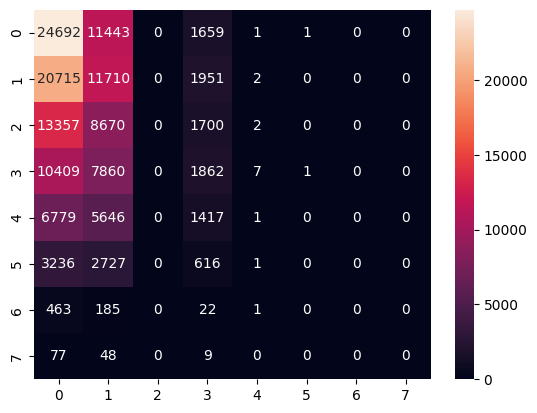

In [14]:
#modeling using the simple bayes approach

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)


print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.22369782181102935


<Axes: >

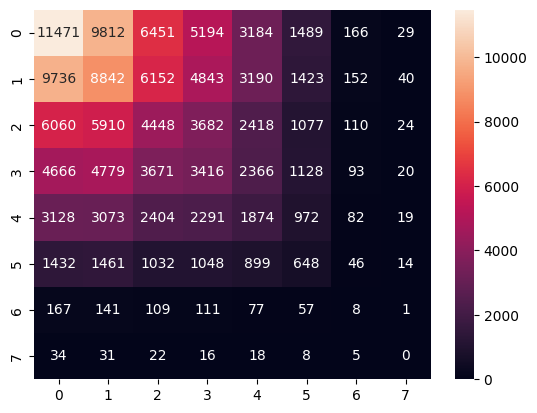

In [15]:
#decision tree approach
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.2937641145188315


<Axes: >

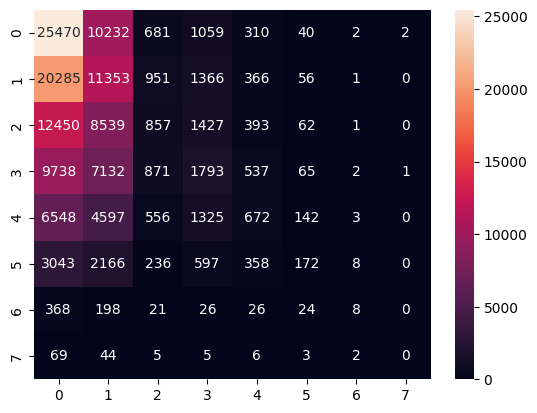

In [17]:
#xgboost approach
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.2571719967946383


<Axes: >

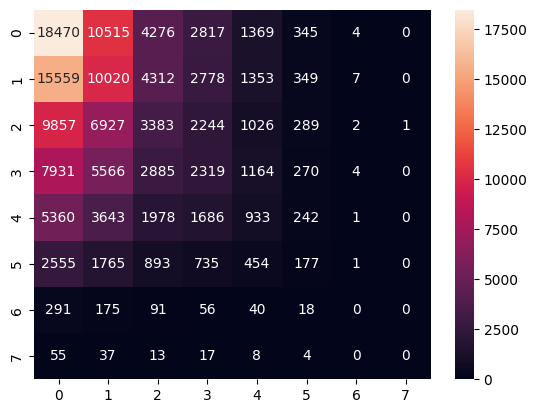

In [18]:
#knn approach

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.26600131128433013


<Axes: >

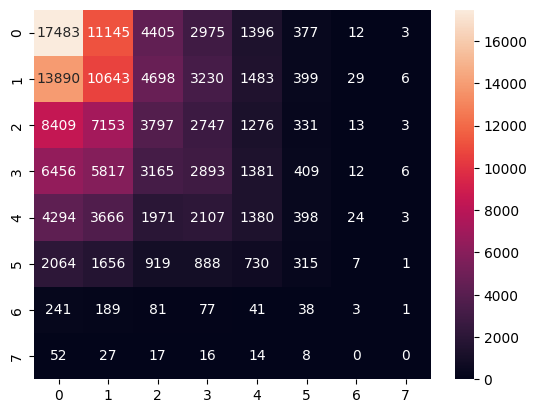

In [19]:
#random forest approach

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [29]:
#Taking a deeper look at the random forest model

#hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2) #no cv cv=0
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END .......................max_depth=5, n_estimators=50; total time=   7.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   6.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=  14.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=  15.7s
[CV] END ......................max_depth=5, n_estimators=200; total time=  31.1s
[CV] END ......................max_depth=5, n_estimators=200; total time=  32.0s
[CV] END ......................max_depth=5, n_estimators=300; total time=  41.9s
[CV] END ......................max_depth=5, n_estimators=300; total time=  41.1s
[CV] END ......................max_depth=10, n_estimators=50; total time=  10.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=  15.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=  31.1s
[CV] END .....................max_depth=10, n_es

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=20, n_estimators=50; total time=  31.3s
[CV] END .....................max_depth=15, n_estimators=200; total time= 1.5min
[CV] END .....................max_depth=15, n_estimators=200; total time= 1.5min
[CV] END .....................max_depth=20, n_estimators=100; total time= 1.1min
[CV] END .....................max_depth=20, n_estimators=100; total time= 1.1min
[CV] END .....................max_depth=15, n_estimators=300; total time= 2.2min
[CV] END .....................max_depth=15, n_estimators=300; total time= 2.2min
[CV] END .....................max_depth=20, n_estimators=200; total time= 1.8min
[CV] END .....................max_depth=20, n_estimators=200; total time= 1.7min
[CV] END .....................max_depth=20, n_estimators=300; total time= 2.2min
[CV] END .....................max_depth=20, n_estimators=300; total time= 2.2min
{'max_depth': 15, 'n_estimators': 200}
0.2880839810882282
RandomForestClassifier(max_depth=15, n_estimators=2

In [30]:
#tuning xgboost
param_grid = {
    'n_estimators': [50, 100, 200, 300,1000],
    'max_depth': [2,3,4,5,6,7,8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 2 folds for each of 140 candidates, totalling 280 fits
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   8.2s
[CV] END ...learning_rate=0.01, max_depth=2, n_estimators=50; total time=   8.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=  15.8s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=  15.9s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  10.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  10.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=  31.8s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=  32.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  20.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  21.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=300; total time=  49.4s
[CV] END ..learning_rate=0.01, max_depth=2, n_